##Check GPU

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

## Install Tensorflow Objectdetection API

In [3]:
# Related Libraries
!apt-get -y install protobuf-compiler python-pil python-lxml python-tk
!pip install matplotlib

# Git clone
!git clone https://github.com/tensorflow/models.git
import os
os.chdir("/content/models")
!git checkout 7f351c62f8e6c6789d76237bfdc43630714b9b8d

# Set PATH
os.chdir("/content/models/research/")
import sys
sys.path.append('/content/models/research')
sys.path.append('/content/models/research/slim')
sys.path.append('/content/models/research/object_detection')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-tk is already the newest version (2.7.15~rc1-1).
The following additional packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6
  libwebpdemux2 libwebpmux3 libxslt1.1 python-bs4 python-chardet
  python-html5lib python-olefile python-pkg-resources python-six
  python-webencodings
Suggested packages:
  liblcms2-utils python-genshi python-lxml-dbg python-lxml-doc python-pil-doc
  python-pil-dbg python-setuptools
The following NEW packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6
  libwebpdemux2 libwebpmux3 libxslt1.1 protobuf-compiler python-bs4
  python-chardet python-html5lib python-lxml python-olefile python-pil
  python-pkg-resources python-six python-webencodings
0 upgraded, 19 newly installed, 0 to remove and 3 not upgraded.
Need to get 3,740 kB of archives.
After this operation, 14.6 MB of addition

## Compile Protobuf Library

In [4]:
os.chdir("/content/models/research/")
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/train.py -> build/lib/object_detection
copying object_detection/eval_util.py -> build/lib/object_detection
copying object_detection/evaluator.py -> build/lib/object_detection
copying object_detection/model_lib.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/exporter_test.py -> build/lib/object_detection
copying object_detection/model_main.py -> build/lib/object_detection
copying object_detection/model_tpu_main.py -> build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/model_lib_test.py -> build/lib/object_detection
copying object_detection/exporter.py -> build/lib/objec

## Build Tensorflow-Slim Model

In [5]:
os.chdir("/content/models/research/slim")
!python setup.py build
!python setup.py install

os.chdir("/content/models/research")
!python object_detection/builders/model_builder_test.py

running build
running build_py
creating build
creating build/lib
creating build/lib/deployment
copying deployment/model_deploy_test.py -> build/lib/deployment
copying deployment/model_deploy.py -> build/lib/deployment
copying deployment/__init__.py -> build/lib/deployment
creating build/lib/preprocessing
copying preprocessing/inception_preprocessing.py -> build/lib/preprocessing
copying preprocessing/preprocessing_factory.py -> build/lib/preprocessing
copying preprocessing/cifarnet_preprocessing.py -> build/lib/preprocessing
copying preprocessing/vgg_preprocessing.py -> build/lib/preprocessing
copying preprocessing/__init__.py -> build/lib/preprocessing
copying preprocessing/lenet_preprocessing.py -> build/lib/preprocessing
creating build/lib/nets
copying nets/alexnet.py -> build/lib/nets
copying nets/inception_v1.py -> build/lib/nets
copying nets/cyclegan.py -> build/lib/nets
copying nets/inception.py -> build/lib/nets
copying nets/alexnet_test.py -> build/lib/nets
copying nets/mobile

## Download SSD model pre-trained by MS-COCO Dataset

In [6]:
os.chdir('/content/models/research/object_detection/')
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz
!tar -xzvf ssd_mobilenet_v1_coco_2017_11_17.tar.gz

--2018-10-17 08:46:31--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.111.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76534733 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  72.99M   186MB/s    in 0.4s    

2018-10-17 08:46:32 (186 MB/s) - ‘ssd_mobilenet_v1_coco_2017_11_17.tar.gz’ saved [76534733/76534733]

ssd_mobilenet_v1_coco_2017_11_17/
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.index
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.meta
ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb
ssd_mobilenet_v1_coco_2017_11_17/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2017_11_17/saved_model/
ssd_mobilenet_v1_coco_2017_11_17/saved_model/saved

## Define Python code

In [7]:
import numpy as np
import sys
import os
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image

from utils import label_map_util
from utils import visualization_utils as vis_util

# モデル読み込み
# TensorflowではTensor(データ)とOperation(計算)から構成されるGraphとしてCNN演算を表現します

# graphオブジェクト生成
detection_graph = tf.Graph() 

# 生成したgraphのコンテキストマネージャを取得
with detection_graph.as_default():
  # graph定義のためのオブジェクトを作成
  od_graph_def = tf.GraphDef()
  
  # モデルファイル(protocol buffer形式)を指定してロード
  with tf.gfile.GFile('ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb', 'rb') as fid:
    # バイナリファイルにシリアライズされたgraphデータを読み込み
    serialized_graph = fid.read()
    # graph構造をparseしてオブジェクトに設定
    od_graph_def.ParseFromString(serialized_graph)
    # graphオブジェクトのdefault_graphに追加
    tf.import_graph_def(od_graph_def, name='')

/content/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist

## Load label map

In [0]:
# ラベルマップの読み込み

# ラベルマップは、分類カテゴリのkey名とidを関連付ける辞書データ(name,id,display_name)
# 例：CNNの出力が"5"の場合"飛行機"に相当する、など
label_map = label_map_util.load_labelmap('data/mscoco_label_map.pbtxt')

# ラベルマップからカテゴリストを取得(id,display_nameのリスト)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)

# カテゴリidを入力としてkey名を取得するための辞書を作成
category_index = label_map_util.create_category_index(categories)

# 画像データを[width,height,3]次元のnumpy配列に変換
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# 入力画像のディレクトリを指定
PATH_TO_TEST_IMAGES_DIR = 'test_images'
# 入力画像のパスを取得
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 
                                  'image{}.jpg'.format(i)) for i in range(1, 3) ]
# 表示する画像のサイズを指定
IMAGE_SIZE = (18, 12)

## Check images

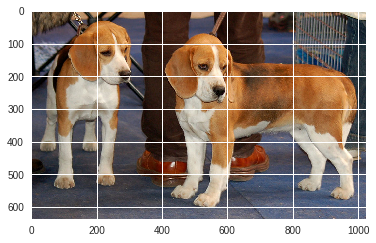

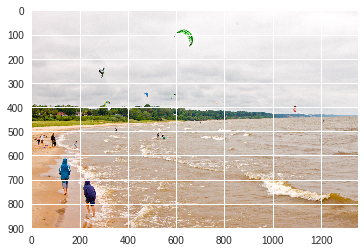

In [9]:
im = Image.open('./test_images/image1.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

im = Image.open('./test_images/image2.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

## Define inference function

In [0]:
# SSD推論処理の実装
# 引数：numpy形式の画像データ, 学習済みモデルのgraph
def run_inference_for_single_image(image, graph):
  # default_graphを呼び出し
  with graph.as_default():
    # graphのSessionを取得
    # SessionはgraphのOperationsをGPUなどのデバイスに配置し実行する手段を提供
    with tf.Session() as sess:
      # Operation一覧を取得
      ops = tf.get_default_graph().get_operations()
      # Operationの出力Tensorの名前を取得
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      
      # Tensor辞書を生成
      tensor_dict = {}
      for key in [
          'num_detections',    # batchの中で検出されたboxの個数
          'detection_boxes',   # 検出されたboxの座標
          'detection_scores',  # 検出されたboxのスコア
          'detection_classes', # 検出されたboxの分類クラス
      ]:
        tensor_name = key + ':0' # 0番目の出力
        
        # 各key名がOperationの出力に含まれている場合
        if tensor_name in all_tensor_names:
          # key名に相当するTensorを学習済みモデルから取得してTensor辞書に登録
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      
      # image_tensorのkey名をもつTensorを学習済みモデルから取得
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # 推論処理実行
      output_dict = sess.run(
                tensor_dict, # 取得したいTensorを指定
                feed_dict={image_tensor: np.expand_dims(image, 0)}) # image_tensorの次元を[1,None,None,3]に変換

      # SSDの出力は全てfloat32なので適切な型に変換
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      
  # SSDの出力から取得したTensorを返す
  return output_dict

## Execute inference

In [11]:
# SSD推論処理の実行

# テスト画像パス読み込み
for image_path in TEST_IMAGE_PATHS:
  # 画像の読み込み
  image = Image.open(image_path)
  # 画像をnumpy配列に変換
  image_np = load_image_into_numpy_array(image)
  # 画像データの0次元目を追加(バッチ分の次元)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # 推論処理の実行
  # 戻り値として辞書に登録したkeyの出力を得る
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # ユーティリティ関数を使用して可視化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,                                         # numpy配列の画像データ
      output_dict['detection_boxes'],   # 検出されたbbox
      output_dict['detection_classes'], # 検出されたbboxのクラス
      output_dict['detection_scores'],  # 検出されたbboxのスコア
      category_index,                               # カテゴリidとカテゴリ名の辞書　
      instance_masks=None,                   # segmentation用マスク（今回は不使用）
      use_normalized_coordinates=True, # 画像サイズで規格化されたbbox位置(ymin, xmin, ymax, xmax)
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

## Check inference results

In [12]:
# output_dictを個々に出力
# 例：スコアが0.5以上の検出結果
(x,y,c) = np.shape(image_np)

for i in range(len(output_dict['detection_classes'])):
  if output_dict['detection_scores'][i] > 0.5:
    print(category_index[output_dict['detection_classes'][i]]['name'],  # 検出されたクラス名
         output_dict['detection_scores'][i], # スコアの値
         np.array(output_dict['detection_boxes'][i].tolist()*np.array([x,y,x,y]), dtype='int')) # 画像上のbox座標

person 0.91687834 [498 532 533 553]
kite 0.82944524 [344 467 361 485]
person 0.77850515 [516  77 561 101]
kite 0.7699845 [ 71 591 149 676]
kite 0.7555387 [239 271 276 301]
person 0.6342344 [615 106 756 159]
kite 0.60740554 [346 583 360 605]
person 0.58910227 [684 212 843 272]
person 0.5123759 [488 346 506 361]
person 0.50146365 [528  36 558  55]


In [14]:
os.chdir('/content/models/research/object_detection/')
!ls

anchor_generators	   metrics
box_coders		   model_hparams.py
builders		   model_lib.py
CONTRIBUTING.md		   model_lib_test.py
core			   model_main.py
data			   models
data_decoders		   model_tpu_main.py
dataset_tools		   object_detection_tutorial.ipynb
eval.py			   protos
evaluator.py		   __pycache__
eval_util.py		   README.md
eval_util_test.py	   samples
exporter.py		   ssd_mobilenet_v1_coco_2017_11_17
exporter_test.py	   ssd_mobilenet_v1_coco_2017_11_17.tar.gz
export_inference_graph.py  test_ckpt
g3doc			   test_data
inference		   test_images
__init__.py		   trainer.py
inputs.py		   trainer_test.py
inputs_test.py		   train.py
matchers		   utils
meta_architectures


In [15]:
!wget https://cdn.pixabay.com/photo/2017/04/27/11/21/dog-2265233_960_720.jpg

--2018-10-17 08:57:35--  https://cdn.pixabay.com/photo/2017/04/27/11/21/dog-2265233_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 213.239.228.134, 213.239.228.180, 213.239.228.182, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|213.239.228.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139251 (136K) [image/jpeg]
Saving to: ‘dog-2265233_960_720.jpg’

dog-2265233_960_720 100%[===================>] 135.99K   616KB/s    in 0.2s    

2018-10-17 08:57:35 (616 KB/s) - ‘dog-2265233_960_720.jpg’ saved [139251/139251]



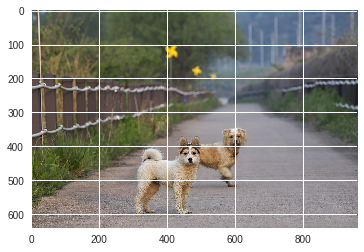

In [18]:
im = Image.open('./dog-2265233_960_720.jpg')
im_arr = np.asarray(im)
plt.imshow(im_arr)
plt.show()

## Run Inference for your Own Data

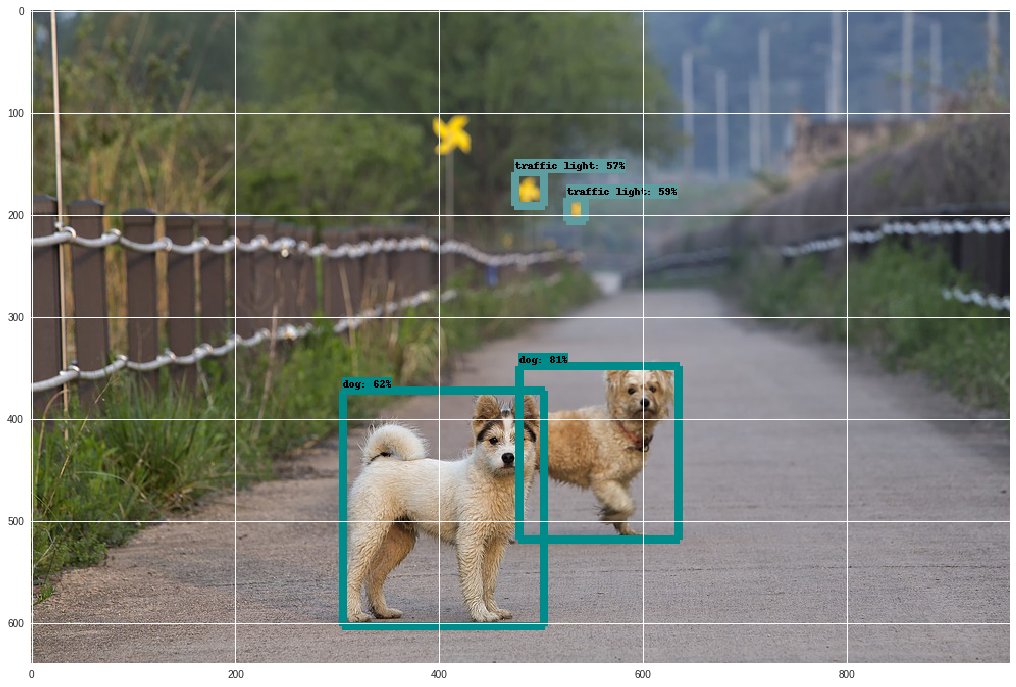

In [16]:
if 1:
  # 画像の読み込み
  image = Image.open('./dog-2265233_960_720.jpg')
  # 画像をnumpy配列に変換
  image_np = load_image_into_numpy_array(image)
  # 画像データの0次元目を追加(バッチ分の次元)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  
  # 推論処理の実行
  # 戻り値として辞書に登録したkeyの出力を得る
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  
  # ユーティリティ関数を使用して可視化
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,                                         # numpy配列の画像データ
      output_dict['detection_boxes'],   # 検出されたbbox
      output_dict['detection_classes'], # 検出されたbboxのクラス
      output_dict['detection_scores'],  # 検出されたbboxのスコア
      category_index,                               # カテゴリidとカテゴリ名の辞書　
      instance_masks=None,                   # segmentation用マスク（今回は不使用）
      use_normalized_coordinates=True, # 画像サイズで規格化されたbbox位置(ymin, xmin, ymax, xmax)
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)